In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Embedding, GlobalMaxPooling1D, Dropout, Input
import matplotlib.pyplot as plt
from util import plot_history
import util
import feature_builder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

Cargo datasets

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Armo features con el feature_builder

In [3]:
def prepare_for_cnn(df):
    processed = feature_builder.process_dataset(
        df,
        encoding_type='binary',
        text_type='embeddings',
        use_spacy=True
    )
    to_numpy = processed.to_numpy()
    to_numpy = to_numpy.reshape(processed.shape[0], processed.shape[1], 1)
    return processed, to_numpy

In [21]:
%%time
processed, train = prepare_for_cnn(train_df)
train_target = train_df['target'].values

Percentage of words covered in the embeddings = 0.4937444933920705
Percentage of words covered in the embeddings = 0.5961027457927369
Wall time: 1min 9s


In [20]:
processed

,invalid_location_character_count,location_is_place,c0,c1,c2,c3,c4,c5,c6,c7,...,spacy_text_embedding_290,spacy_text_embedding_291,spacy_text_embedding_292,spacy_text_embedding_293,spacy_text_embedding_294,spacy_text_embedding_295,spacy_text_embedding_296,spacy_text_embedding_297,spacy_text_embedding_298,spacy_text_embedding_299
0,0,0,0,0,0,0,0,0,0,0,...,-0.065948,0.016541,-0.029419,0.201294,-0.134033,-0.022797,-0.096130,-0.082275,0.024780,-0.035091
1,0,0,0,0,0,0,0,0,0,0,...,-0.103048,-0.008789,-0.073283,0.087118,0.050903,0.021362,-0.066895,-0.053345,-0.035055,-0.015259
2,0,0,0,0,0,0,0,0,0,0,...,-0.099365,-0.028531,-0.146620,0.124478,0.018745,0.093262,0.000203,-0.068373,0.106174,0.032135
3,0,0,0,0,0,0,0,0,0,0,...,-0.045573,-0.119141,0.007790,0.326172,0.279622,0.003174,-0.174154,-0.052409,0.009115,0.055501
4,0,0,0,0,0,0,0,0,0,0,...,0.103882,-0.007446,-0.152100,0.100342,-0.039429,0.087555,-0.188110,0.112869,0.039062,0.046783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,0,0,0,0,0,0,0,0,0,0,...,-0.019643,-0.027425,-0.088216,0.140259,0.053004,0.038127,-0.009115,-0.041951,-0.016642,-0.073298
3259,0,0,0,0,0,0,0,0,0,0,...,-0.010395,0.092642,-0.119723,0.056678,-0.038451,-0.008188,-0.197838,0.001563,-0.042161,0.055533
3260,0,0,0,0,0,0,0,0,0,0,...,0.034895,0.042254,-0.021009,0.150600,0.022862,-0.101911,0.003104,-0.039464,0.002563,0.060952
3261,0,0,0,0,0,0,0,0,0,0,...,0.091390,0.099274,-0.108032,-0.043513,0.028402,0.013509,-0.000753,0.020945,0.164876,-0.098124


In [22]:
X_train, X_pred, y_train, y_pred = train_test_split(train, train_target, test_size=0.001, random_state=42)

In [23]:
X_train.shape

(7605, 640, 1)

In [24]:
X_pred.shape

(8, 640, 1)

Creo el modelo y corro la CNN

In [25]:
def create_model(filters, kernel_sizes, pool_sizes, units, cnn_layers, dense_layers):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    
    for i in range(cnn_layers):
        model.add(Conv1D(filters=filters[i], kernel_size=kernel_sizes[i], activation='relu'))
    model.add(MaxPooling1D(2))#pool_sizes[i]))

    model.add(Flatten())
    
    for i in range(dense_layers):
        model.add(Dense(units[i], activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-4), metrics=['accuracy'])
    return model

In [26]:
filters=[32,32,64]
kernel_size=[3,3,3]
pool_sizes=[2,2,2]
units=[64]
cnn_layers=3
dense_layers=1

In [27]:
filters=[64]
kernel_size=[3]
pool_sizes=[2]
units=[32]
cnn_layers=1
dense_layers=1

In [28]:
#acc = 0.8
filters=[128,128]
kernel_size=[3,3,3]
pool_sizes=[2,2,2]
units=[32, 32]
cnn_layers=2
dense_layers=2

In [29]:
#acc = 0.80 cleaner
filters=[128,128,128]
kernel_size=[3,4,5]
pool_sizes=[2,2,2]
units=[64,64,64]
cnn_layers=3
dense_layers=3

Epoch 1/12
476/476 [==============================] - 40s 85ms/step - loss: 0.6102 - accuracy: 0.6619 - val_loss: 0.7439 - val_accuracy: 0.5000
Epoch 2/12
476/476 [==============================] - 43s 90ms/step - loss: 0.4715 - accuracy: 0.7936 - val_loss: 0.8260 - val_accuracy: 0.5000
Epoch 3/12
476/476 [==============================] - 43s 90ms/step - loss: 0.4415 - accuracy: 0.8124 - val_loss: 0.8954 - val_accuracy: 0.5000


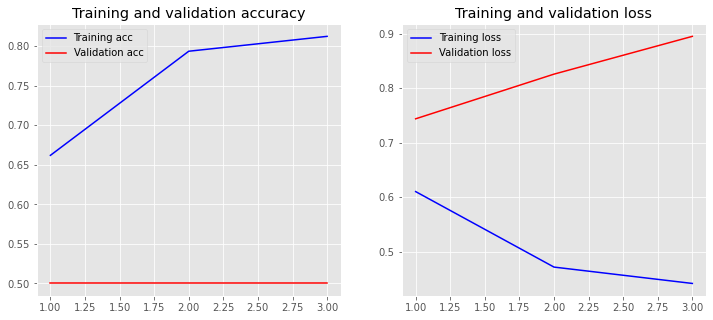

In [30]:
model = create_model(
    filters=filters,
    kernel_sizes=kernel_size,
    pool_sizes=pool_sizes,
    units=units,
    cnn_layers=cnn_layers,
    dense_layers=dense_layers
)
es = keras.callbacks.EarlyStopping(patience=2)
history = model.fit(X_train, y_train, epochs=12, shuffle=True, validation_data=(X_pred, y_pred), callbacks=[es], batch_size=16)
plot_history(history)

Calculemos el test para kaggle

In [31]:
prediction = model.predict_classes(X_pred)
f1 = f1_score(y_pred, [x[0] for x in prediction])
print(f'F1 Score: {f1}')

F1 Score: 0.0


In [32]:
ids = test_df['id']

processed, final_test = prepare_for_cnn(test_df)
prediction = model.predict_classes(final_test)

final_df = pd.DataFrame({'target': [x[0] for x in prediction]}, index=ids)
final_df

Percentage of words covered in the embeddings = 0.5707598689343111
Percentage of words covered in the embeddings = 0.665389037945573


,target
id,
0,1
2,0
3,1
9,1
11,1
...,...
10861,0
10865,1
10868,1


In [33]:
final_df['target'].value_counts()

0    2342
1     921
Name: target, dtype: int64

In [34]:
final_df.count()

target    3263
dtype: int64

In [35]:
final_df.to_csv('cnn_loc.csv')